In [1]:
import pandas as pd
import geopandas as gpd
import pycountry
from fuzzywuzzy import process

c:\Users\gabriel.genelot\AppData\Local\Programs\Python\Python312\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Wiliam regions



In [2]:
wiliam = pd.read_csv('WILIAM_regions.csv')
wiliam['Regions'] = wiliam['Regions'].str.strip()
wiliam.head()

,Regions,WILIAM
0,Austria,AUSTRIA
1,Belgium,BELGIUM
2,Bulgaria,BULGARIA
3,Croatia,CROATIA
4,Cyprus,CYPRUS


Now we have to match these regions back with WILIAM's regions. We asked ChatGPT to provide a list of the region of each country from the map available in the WILIAM documentation. 

![wiliam_regions.jpg](<attachment:Sans titre.jpg>)

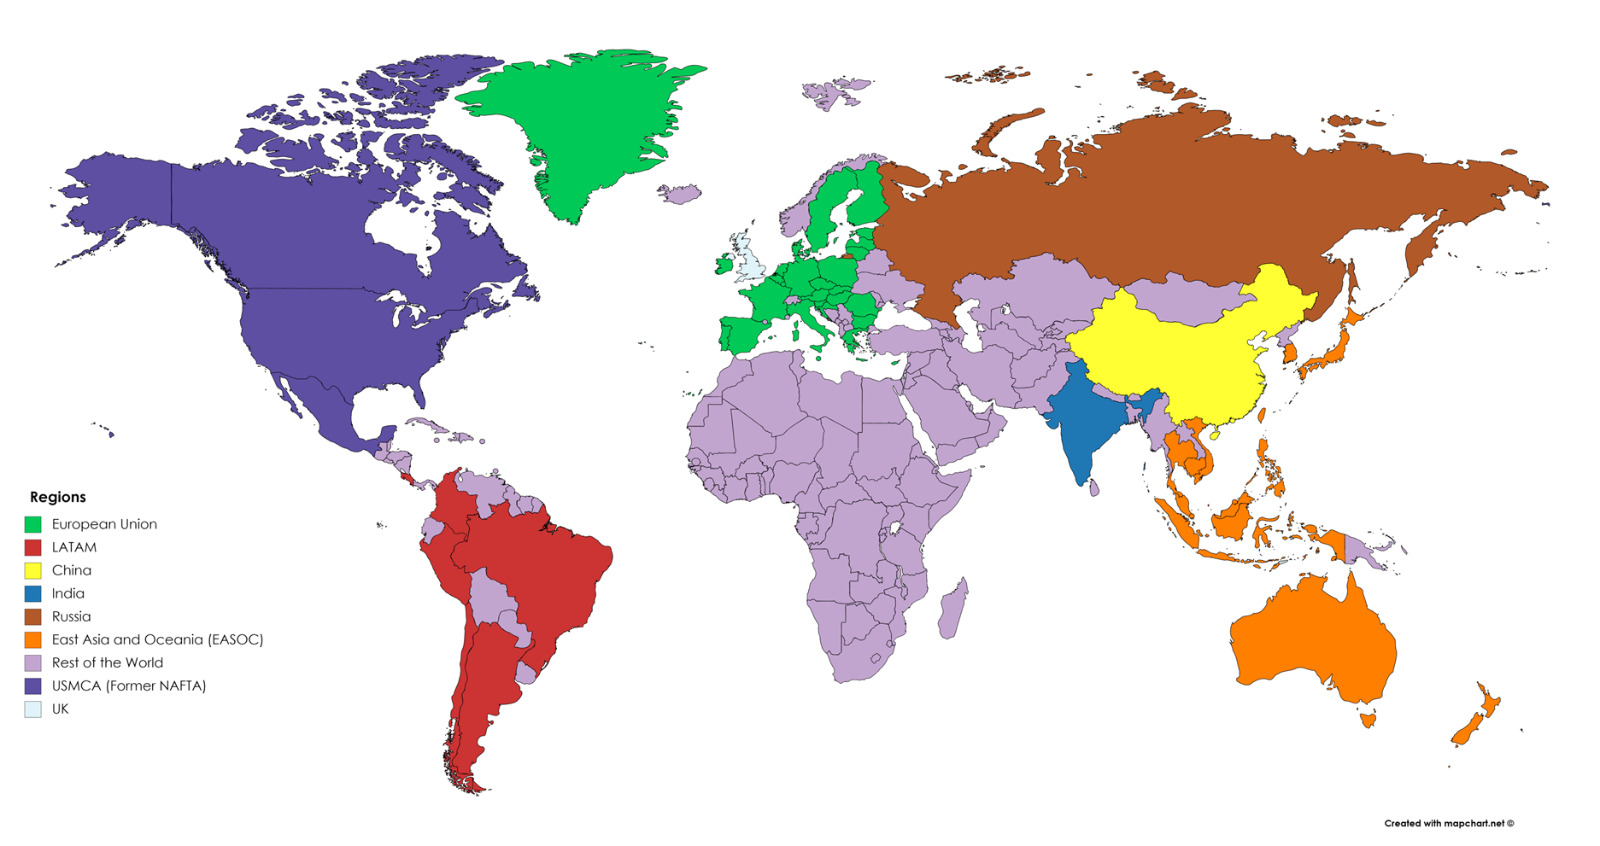

In [3]:

# Defining the regions based on the map's legend
regions = {
    'European Union': ['Ireland', 'Portugal', 'Spain', 'France', 'Belgium', 'Netherlands', 'Luxembourg', 'Germany', 'Denmark', 'Poland', 'Czech Republic', 'Slovakia', 'Hungary', 'Austria', 'Slovenia', 'Italy', 'Croatia', 'Romania', 'Bulgaria', 'Greece', 'Sweden', 'Finland', 'Estonia', 'Latvia', 'Lithuania'],
    'LATAM': ['Mexico', 'Guatemala', 'Honduras', 'El Salvador', 'Nicaragua', 'Costa Rica', 'Panama', 'Colombia', 'Venezuela', 'Ecuador', 'Peru', 'Brazil', 'Bolivia', 'Paraguay', 'Chile', 'Argentina', 'Uruguay'],
    'CHINA': ['China'],
    'INDIA': ['India'],
    'RUSSIA': ['Russia'],
    'EASOC': ['Japan', 'South Korea', 'Taiwan', 'Australia', 'New Zealand'],
    'LROW': ['Greenland', 'Iceland', 'Norway', 'Switzerland', 'Liechtenstein', 'Bosnia and Herzegovina', 'Serbia', 'Montenegro', 'Kosovo', 'Albania', 'North Macedonia', 'Moldova', 'Ukraine', 'Belarus', 'Georgia', 'Armenia', 'Azerbaijan', 'Turkey', 'Cyprus', 'Malta', 'Lebanon', 'Israel', 'Palestine', 'Jordan', 'Syria', 'Iraq', 'Saudi Arabia', 'Kuwait', 'Bahrain', 'Qatar', 'United Arab Emirates', 'Oman', 'Yemen', 'Egypt', 'Libya', 'Tunisia', 'Algeria', 'Morocco', 'Western Sahara', 'Mauritania', 'Mali', 'Senegal', 'Gambia', 'Guinea-Bissau', 'Guinea', 'Sierra Leone', 'Liberia', 'Ivory Coast', 'Ghana', 'Togo', 'Benin', 'Burkina Faso', 'Niger', 'Nigeria', 'Chad', 'Cameroon', 'Central African Republic', 'South Sudan', 'Sudan', 'Eritrea', 'Djibouti', 'Somalia', 'Ethiopia', 'Uganda', 'Rwanda', 'Burundi', 'Democratic Republic of the Congo', 'Republic of the Congo', 'Gabon', 'Equatorial Guinea', 'Sao Tome and Principe', 'Angola', 'Zambia', 'Zimbabwe', 'Malawi', 'Mozambique', 'Madagascar', 'Namibia', 'Botswana', 'Eswatini', 'Lesotho', 'South Africa', 'Comoros', 'Mauritius', 'Seychelles', 'Tanzania', 'Kenya'],
    'USMCA': ['United States of America', 'Canada'],
    'UK': ['United Kingdom']
}

# Creating the dataframe
data = []

for region, countries in regions.items():
    for country in countries:
        data.append([country, region])

gpt_wiliam = pd.DataFrame(data, columns=['Country', 'Region'])

#import ace_tools as tools; tools.display_dataframe_to_user(name="Country-Region DataFrame", dataframe=df)

In [4]:
gpt_wiliam['Region'] = gpt_wiliam.apply(lambda row: row['Country'].upper() if row['Region'] == 'European Union' else row['Region'], axis=1)
gpt_wiliam.head()

,Country,Region
0,Ireland,IRELAND
1,Portugal,PORTUGAL
2,Spain,SPAIN
3,France,FRANCE
4,Belgium,BELGIUM


In [5]:
wiliam_expanded = wiliam.merge(gpt_wiliam, left_on='WILIAM', right_on='Region', how='right')
wiliam_expanded.head()

,Regions,WILIAM,Country,Region
0,Ireland,IRELAND,Ireland,IRELAND
1,Portugal,PORTUGAL,Portugal,PORTUGAL
2,Spain,SPAIN,Spain,SPAIN
3,France,FRANCE,France,FRANCE
4,Belgium,BELGIUM,Belgium,BELGIUM


## Adding the regions from FUND

In [6]:
fund = pd.read_csv('FUND_regions.csv')
fund['Countries'] = fund['Countries'].str.split(',')
fund_exploded = fund.explode('Countries')
fund_exploded.head()

,Code,Name,Countries
0,USA,USA,United States of America
1,CAN,Canada,Canada
2,WEU,Western Europe,Andorra
2,WEU,Western Europe,Austria
2,WEU,Western Europe,Belgium


In [7]:
def get_iso_code(country_name):
    if country_name == 'Russia':
        country_name = 'Russian Federation'
    elif country_name == 'Turkey':
        country_name = 'Türkiye'
    elif country_name == 'Congo-Kinshasa':
        country_name = 'Congo, The Democratic Republic of the'
    elif country_name == 'Congo-Brazzaville':
        country_name = 'Congo'
    elif country_name == 'Swaziland':
        country_name = 'Eswatini'

    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except LookupError:
        return None
    
all_country_names = [country.name for country in pycountry.countries]
    
def get_best_match(country_name):
    best_match, score = process.extractOne(country_name, all_country_names)
    return best_match if score > 80 else None
    
def get_iso_code_fuzzy(country_name):

    try:
        return pycountry.countries.lookup(get_best_match(country_name)).alpha_3
    except LookupError:
        return None


fund_exploded['ISO'] = fund_exploded['Countries'].apply(get_iso_code)
fund_exploded['ISO'] = fund_exploded['ISO'].fillna(fund_exploded['Countries'].apply(get_iso_code_fuzzy))
fund_exploded

,Code,Name,Countries,ISO
0,USA,USA,United States of America,USA
1,CAN,Canada,Canada,CAN
2,WEU,Western Europe,Andorra,AND
2,WEU,Western Europe,Austria,AUT
2,WEU,Western Europe,Belgium,BEL
...,...,...,...,...
15,SIS,Small Island States,Tonga,TON
15,SIS,Small Island States,Trinidad and Tobago,TTO
15,SIS,Small Island States,Tuvalu,TUV
15,SIS,Small Island States,Vanuatu,VUT


In [8]:
rows_with_na = fund_exploded[fund_exploded['ISO'].isna()]
mismatch = rows_with_na['Countries'].values





# Get the ISO codes for the non-matching countries
fuzzy_matches = {country: get_iso_code(get_best_match(country)) for country in mismatch}

fuzzy_matches

{' FYR Macedonia': None,
 ' Turkey': None,
 ' Laos': None,
 ' Macau': None,
 ' Cape Verde': None,
 ' Swaziland': None}

In [9]:
wiliam_expanded['Country'] = wiliam_expanded['Country'].str.strip()
fund_exploded['Countries'] = fund_exploded['Countries'].str.strip()

In [10]:
correspondance = wiliam_expanded.merge(fund_exploded, left_on='Country', right_on='Countries', how='outer')
correspondance = correspondance.rename(columns={'Code': 'Region_FUND_code', 
                                                'Name': 'Region_FUND_name', 
                                                'WILIAM': 'Region_WILIAM'})
correspondance = correspondance.drop(columns=['Regions'])
correspondance.to_csv('correspondance.csv', index=False)
correspondance

,Region_WILIAM,Country,Region,Region_FUND_code,Region_FUND_name,Countries,ISO
0,NaN,NaN,NaN,SAS,South Asia,Afghanistan,AFG
1,LROW,Albania,LROW,CEE,Central and Eastern Europe,Albania,ALB
2,LROW,Algeria,LROW,NAF,North Africa,Algeria,DZA
3,NaN,NaN,NaN,WEU,Western Europe,Andorra,AND
4,LROW,Angola,LROW,SSA,Sub-Saharan Africa,Angola,AGO
...,...,...,...,...,...,...,...
214,LROW,Western Sahara,LROW,NAF,North Africa,Western Sahara,ESH
215,LROW,Yemen,LROW,MDE,Middle East,Yemen,YEM
216,NaN,NaN,NaN,CEE,Central and Eastern Europe,Yugoslavia,LVA
217,LROW,Zambia,LROW,SSA,Sub-Saharan Africa,Zambia,ZMB


## Correspondance with WILIAM regions



In [18]:
base_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base_map = base_map.merge(correspondance, left_on='iso_a3', right_on='ISO', how='left')

C:\Users\gabriel.genelot\AppData\Local\Temp\ipykernel_15160\3723703711.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  base_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<Axes: >

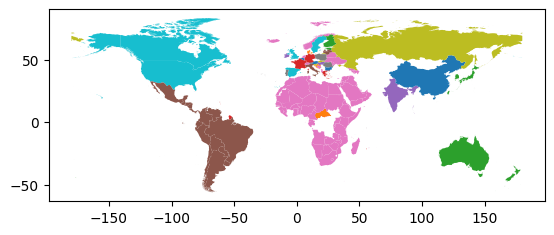

In [23]:
map.plot(column='Region')

<Axes: >

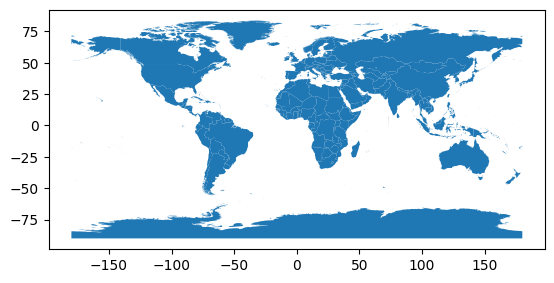

In [11]:
countries = gpd.read_file(r'naturalearthdata\ne_10m_admin_0_countries.shp')
countries.plot()

<Axes: >

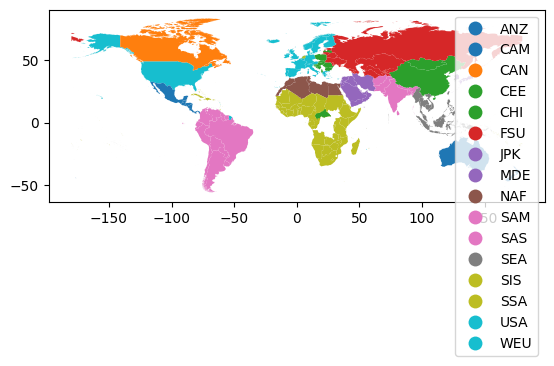

In [12]:
map = countries.merge(correspondance, left_on='ADM0_A3', right_on='ISO', how='left') 
map.plot(column='Region_FUND_code', legend=True)

<Axes: >

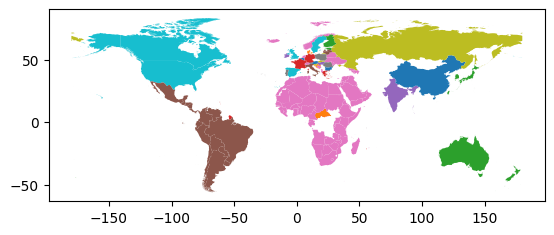

In [13]:
map.plot(column='Region')

In the end I'd rather use the lowress file because I intend to plot mostly large scale maps. 

In [24]:
# Assuming you have a GeoDataFrame named 'geodataframe'
base_map.to_file('output_countries/countries.shp', driver='ESRI Shapefile')

C:\Users\gabriel.genelot\AppData\Local\Temp\ipykernel_15160\2697682444.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  base_map.to_file('output_countries/countries.shp', driver='ESRI Shapefile')


In [16]:
map.columns

Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN',
       ...
       'FCLASS_BD', 'FCLASS_UA', 'geometry', 'Region_WILIAM', 'Country',
       'Region', 'Region_FUND_code', 'Region_FUND_name', 'Countries', 'ISO'],
      dtype='object', length=176)